In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, join, vstack, hstack
import fitsio
from astropy.io import fits

In [2]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
import desimodel.io
from bokeh.models import ColumnDataSource

In [4]:
# io.py
def read_qa(filename):
    '''
    Read QA data from qa-EXPID.fits file
    
    Returns qadata dict with keys HEADER, plus any PER_XYZ EXTNAMEs in the
    input file, and FIBERMAP if it is in the input file
    '''
    qadata = dict()
    with fitsio.FITS(filename) as fx:
        qadata['HEADER'] = fx[0].read_header()
        for hdu in fx:
            extname = hdu.get_extname()
            if extname.startswith('PER_') or extname == 'FIBERMAP':
                qadata[extname] = hdu.read()
    
    return qadata

def get_cds(data, attributes, cameras):
    '''
    Creates a column data source from DATA
    Args:
        data : a fits file of camfib data collected
        attributes : a list of metrics
        cameras : a list of cameras
    Options:
        agg : get an aggregated column data source
            to plot per fiber number instead of
            focal plane

    Returns a bokeh ColumnDataSource object
    '''
    #- Get the positions of the fibers on the focal plane
    fiberpos = Table(desimodel.io.load_fiberpos())
    fiberpos.remove_column('SPECTRO')

    #- Join the metrics data with the corresponding fibers
    #- TODO: use input fibermap instead
    data = Table(data)
    if len(data) > 0:
        data = join(data, fiberpos, keys='FIBER')

    #- bytes vs. strings
    for colname in data.colnames:
        if data[colname].dtype.kind == 'S':
            data[colname] = data[colname].astype(str)

    cds = create_cds(data, attributes)
    return cds


def create_cds(data, attributes, bin_size=25):
    '''
    Creates a column data source from DATA with metrics in ATTRIBUTES
    Args:
        data : an astropy table of camfib data collected
        attributes : a list of metrics
    '''
    data_dict = dict({})

    for colname in data.dtype.names:
        if colname in attributes:
            data_dict[colname] = data[colname].astype(np.float32)
        else:
            data_dict[colname] = data[colname]

    cds = ColumnDataSource(data=data_dict)
    return cds

In [34]:
infile = '/exposures/nightwatch/20191126/00030156/qa-00030156.fits'
qadata = read_qa(infile)

attributes = ['INTEG_RAW_FLUX', 'MEDIAN_RAW_FLUX', 'MEDIAN_RAW_SNR', 'INTEG_CALIB_FLUX',
             'MEDIAN_CALIB_FLUX', 'MEDIAN_CALIB_SNR']
cameras = ['B', 'R', 'Z']

cds = get_cds(qadata['PER_CAMFIBER'], attributes, cameras)
qadata = Table(cds.data)

camera = 'B'
snr_cut = 2

mask = qadata['CAM']==camera
qadata = qadata[mask]

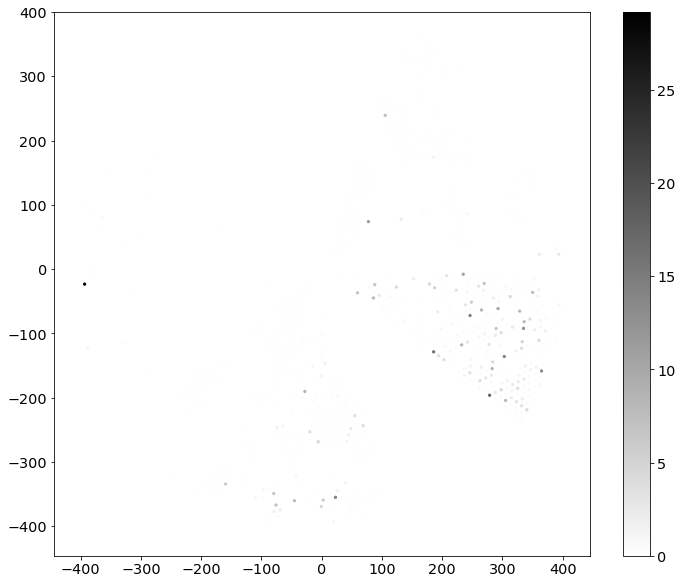

In [6]:
plt.figure(figsize=(12, 10))
plt.scatter(qadata['X'], qadata['Y'], s=5, c=qadata['MEDIAN_CALIB_SNR'], cmap='gray_r', vmin=0)
plt.colorbar()
plt.show()

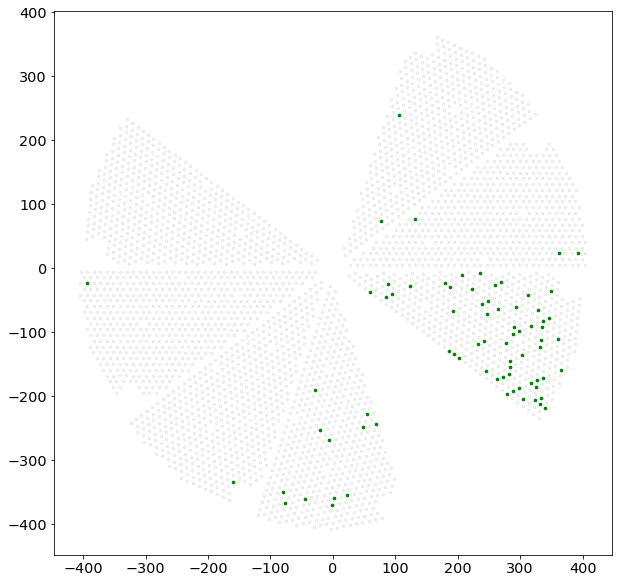

In [7]:
mask = (qadata['MEDIAN_CALIB_SNR']>snr_cut)

plt.figure(figsize=(10, 10))
plt.scatter(qadata['X'][mask], qadata['Y'][mask], s=7, c='green')
plt.scatter(qadata['X'][~mask], qadata['Y'][~mask], s=7, c='gray', alpha=0.1)
# plt.colorbar()
plt.show()

-------

__Add fiberassign data__

In [8]:
tilehdu = fits.open('fiberassign-063068.fits')
tiledata = tilehdu['FIBERASSIGN'].data

In [59]:
tiledata.dtype.names

('TARGETID',
 'PETAL_LOC',
 'DEVICE_LOC',
 'LOCATION',
 'FIBER',
 'FIBERSTATUS',
 'TARGET_RA',
 'TARGET_DEC',
 'PMRA',
 'PMDEC',
 'PMRA_IVAR',
 'PMDEC_IVAR',
 'REF_EPOCH',
 'LAMBDA_REF',
 'FA_TARGET',
 'FA_TYPE',
 'OBJTYPE',
 'FIBERASSIGN_X',
 'FIBERASSIGN_Y',
 'NUMTARGET',
 'PRIORITY',
 'SUBPRIORITY',
 'OBSCONDITIONS',
 'NUMOBS_MORE',
 'RELEASE',
 'BRICKID',
 'BRICKNAME',
 'BRICK_OBJID',
 'MORPHTYPE',
 'TARGET_RA_IVAR',
 'TARGET_DEC_IVAR',
 'EBV',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'MW_TRANSMISSION_G',
 'MW_TRANSMISSION_R',
 'MW_TRANSMISSION_Z',
 'FRACFLUX_G',
 'FRACFLUX_R',
 'FRACFLUX_Z',
 'FRACMASKED_G',
 'FRACMASKED_R',
 'FRACMASKED_Z',
 'FRACIN_G',
 'FRACIN_R',
 'FRACIN_Z',
 'NOBS_G',
 'NOBS_R',
 'NOBS_Z',
 'PSFDEPTH_G',
 'PSFDEPTH_R',
 'PSFDEPTH_Z',
 'GALDEPTH_G',
 'GALDEPTH_R',
 'GALDEPTH_Z',
 'FLUX_W1',
 'FLUX_W2',
 'FLUX_W3',
 'FLUX_W4',
 'FLUX_IVAR_W1',
 'FLUX_IVAR_W2',
 'FLUX_IVAR_W3',
 'FLUX_IVAR_W4',
 'MW_TRANSMISSION_W1',
 'M

In [9]:
qadata = join(tiledata, qadata, 'FIBER')

In [12]:
qadata.colnames

['TARGETID',
 'PETAL_LOC',
 'DEVICE_LOC',
 'LOCATION_1',
 'FIBER',
 'FIBERSTATUS',
 'TARGET_RA',
 'TARGET_DEC',
 'PMRA',
 'PMDEC',
 'PMRA_IVAR',
 'PMDEC_IVAR',
 'REF_EPOCH',
 'LAMBDA_REF',
 'FA_TARGET',
 'FA_TYPE',
 'OBJTYPE',
 'FIBERASSIGN_X',
 'FIBERASSIGN_Y',
 'NUMTARGET',
 'PRIORITY',
 'SUBPRIORITY',
 'OBSCONDITIONS',
 'NUMOBS_MORE',
 'RELEASE',
 'BRICKID',
 'BRICKNAME',
 'BRICK_OBJID',
 'MORPHTYPE',
 'TARGET_RA_IVAR',
 'TARGET_DEC_IVAR',
 'EBV',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'MW_TRANSMISSION_G',
 'MW_TRANSMISSION_R',
 'MW_TRANSMISSION_Z',
 'FRACFLUX_G',
 'FRACFLUX_R',
 'FRACFLUX_Z',
 'FRACMASKED_G',
 'FRACMASKED_R',
 'FRACMASKED_Z',
 'FRACIN_G',
 'FRACIN_R',
 'FRACIN_Z',
 'NOBS_G',
 'NOBS_R',
 'NOBS_Z',
 'PSFDEPTH_G',
 'PSFDEPTH_R',
 'PSFDEPTH_Z',
 'GALDEPTH_G',
 'GALDEPTH_R',
 'GALDEPTH_Z',
 'FLUX_W1',
 'FLUX_W2',
 'FLUX_W3',
 'FLUX_W4',
 'FLUX_IVAR_W1',
 'FLUX_IVAR_W2',
 'FLUX_IVAR_W3',
 'FLUX_IVAR_W4',
 'MW_TRANSMISSION_W1',
 

In [10]:
def bitmask_summary(mask_values, names, bits):
    mask_values = np.array(mask_values, dtype=np.uint64)
    t = Table()
    t['name'] = names
    t['bit'] = bits
    t['count'] = 0
    for index in range(len(bits)):
        bit = bits[index]
        t['count'][index] = np.sum(mask_values & (2**bit)>0)
    t['frac (%)'] = t['count']/len(mask_values)*100
    t['frac (%)'].format = "%.3f"
    return t

In [11]:
bitvalues = [0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 32, 33, 35, 36, 37]
bitnames = ['STD_GAIA', 'SV0_STD_FAINT', 'SV0_STD_BRIGHT', 'STD_TEST', 'STD_CALSPEC', 'STD_DITHER', 'SV0_BGS', 'SV0_MWS', 'SV0_LRG', 'SV0_ELG', 'SV0_QSO', 'SV0_WD', 'BACKUP_BRIGHT', 'BACKUP_FAINT', 'M31_STD_BRIGHT', 'M31_H2PN', 'M31_GC', 'M31_QSO', 'M31_VAR', 'M31_BSPL', 'M31_M31cen', 'M31_M31out', 'ORI_STD_BRIGHT', 'ORI_QSO', 'ORI_ORI', 'ORI_HA', 'ROS_STD_BRIGHT', 'ROS_QSO', 'ROS_ROSM17', 'ROS_ROS1', 'ROS_HA', 'ROS_ROS2', 'M33_STD_BRIGHT', 'M33_H2PN', 'M33_GC', 'M33_QSO', 'M33_M33cen', 'M33_M33out', 'SKY', 'STD_FAINT', 'STD_BRIGHT', 'BAD_SKY', 'SUPP_SKY']

In [12]:
t = bitmask_summary(tiledata['CMX_TARGET'], bitnames, bitvalues)
t = t[t['count']>0]
t.sort('count')
t

name,bit,count,frac (%)
str14,int64,int64,float64
SV0_ELG,11,1,0.020
SV0_LRG,10,2,0.040
SV0_WD,13,2,0.040
SV0_QSO,12,12,0.240
SV0_STD_FAINT,1,100,2.000
STD_FAINT,33,100,2.000
SV0_STD_BRIGHT,2,113,2.260
STD_BRIGHT,35,113,2.260
STD_TEST,3,488,9.760


In [32]:
snmask = (qadata['MEDIAN_CALIB_SNR']>snr_cut)
skymask = (qadata['CMX_TARGET'] & 2**32 > 0)
print('# sky fibers:', np.sum(skymask))

# sky fibers: 0


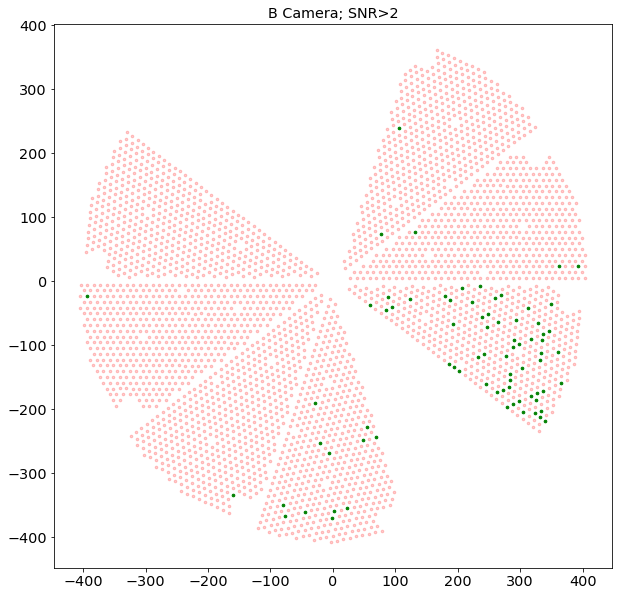

In [33]:
plt.figure(figsize=(10, 10))
mask = snmask & (~skymask)
plt.scatter(qadata['X'][mask], qadata['Y'][mask], s=7, c='green')
mask = (~snmask) & (~skymask)
plt.scatter(qadata['X'][mask], qadata['Y'][mask], s=7, c='red', alpha=0.2)
plt.scatter(qadata['X'][skymask], qadata['Y'][skymask], s=7, c='cyan', alpha=1)
# plt.colorbar()
plt.title('{} Camera; SNR>{}'.format(camera, snr_cut))
plt.show()